# Process Control Project Simulations

## Boilerplate

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import interact
import packages.pc as pc

import importlib
importlib.reload(pc)

<module 'packages.pc' from 'c:\\Users\\jared\\OneDrive - Brigham Young University\\BYU\\6 - Fall 24\\Process Control\\balanceProject\\Software\\packages\\pc.py'>

## Dr. Hedengren's Draft (GEKKO, AI)

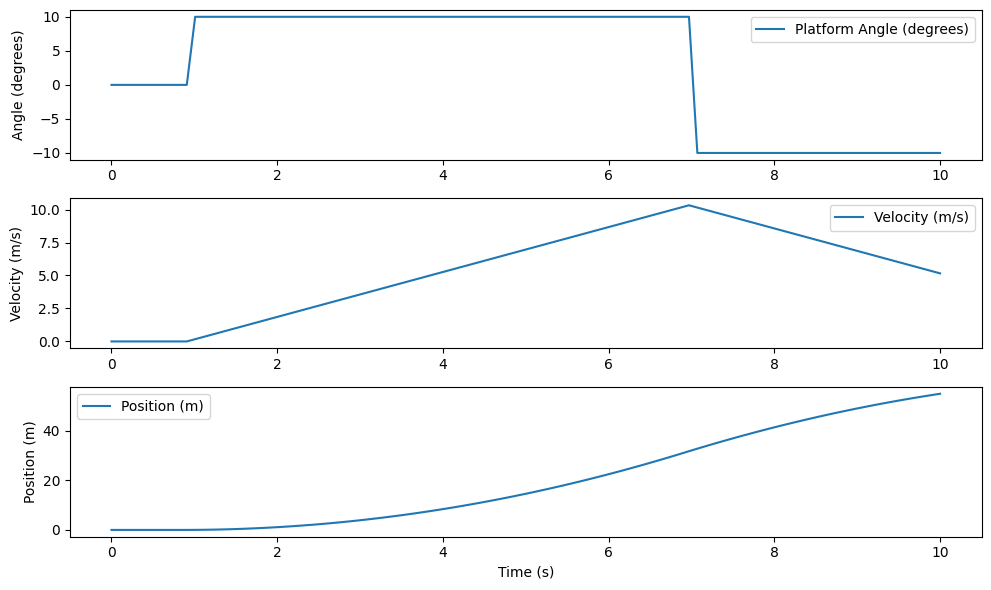

In [10]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize Gekko Model
m = GEKKO(remote=False)

# Time horizon
m.time = np.linspace(0, 10, 100)  # 0 to 10 seconds, 100 points

# Parameters and Variables
theta = m.Param(value=0)  # Platform angle (degrees)
g = 9.81                  # Gravity (m/s^2)
x = m.Var(value=0)        # Position of the ball (m)
v = m.Var(value=0)        # Velocity of the ball (m/s)
a = m.Var(value=0)        # Acceleration of the ball (m/s^2)

# Equations of motion
m.Equation(a == g * m.sin(theta * np.pi / 180))  # Convert angle to radians
m.Equation(v.dt() == a)  # Velocity is the derivative of position
m.Equation(x.dt() == v)  # Position is the integral of velocity

# Simulate angle changes (e.g., sinusoidal variation)
angle_profile = 10 * np.sin(m.time * np.pi / 5)  # Varies between ±10 degrees
angle_profile = np.zeros(m.time.shape)
angle_profile[10:] = 10
angle_profile[70:] = -10
theta.value = angle_profile

# Set simulation mode
m.options.IMODE = 4  # Dynamic simulation

# Solve the model
m.solve(disp=False)

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(m.time, theta.value, label='Platform Angle (degrees)')
plt.ylabel('Angle (degrees)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(m.time, v.value, label='Velocity (m/s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(m.time, x.value, label='Position (m)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()

plt.tight_layout()
plt.show()

## Open Loop Testing

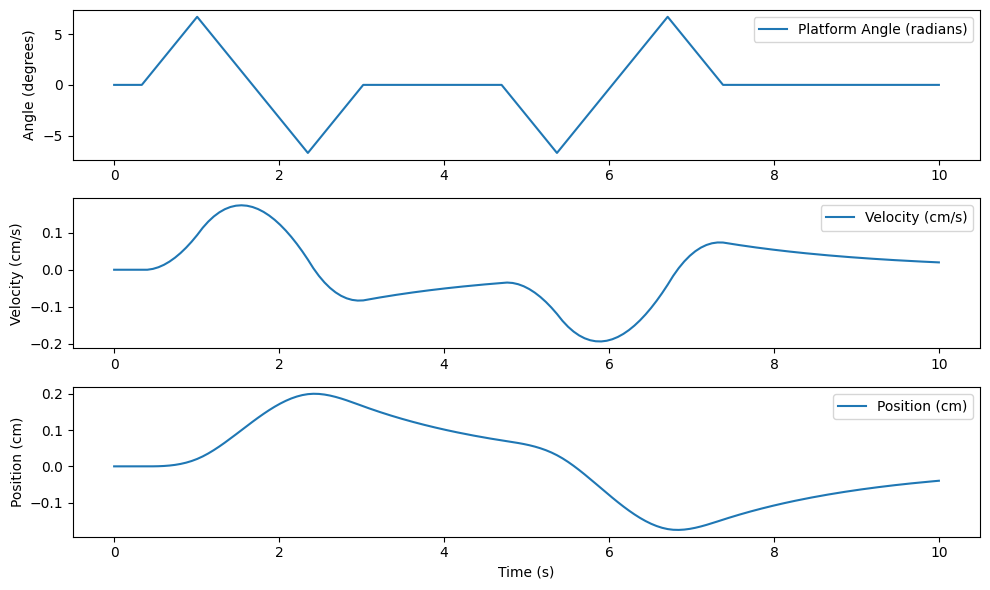

In [73]:
# Process Parameters
maxTime = 10
maxTheta = 25     # deg
maxDTheta = 10    # deg/s
nPts = 150
m = 3/1000 # kg
g = 9.81 # m/s^2
b = 1.5e-3 # Ns/m (damping coefficient)

# Process Variable Arrays
times = np.linspace(0, maxTime, nPts)
dTheta = np.zeros(len(times)) # deg/s
theta = np.zeros(len(times))  # deg
pos = np.zeros(len(times))
vel = np.zeros(len(times))

# Set changes
dTheta[5:] = maxDTheta
dTheta[15:] = -maxDTheta
dTheta[35:] = maxDTheta
dTheta[45:] = 0
dTheta[70:] = -maxDTheta
dTheta[80:] = maxDTheta
dTheta[100:] = -maxDTheta
dTheta[110:] = 0

# Lever differential equation
def lever(state, t):
    thetaVal, dThetaVal = state
    return dThetaVal, 0

# Ball differential equation
def ball(state, t, thetaVal):
    x, dx = state
    return dx, m*g*np.sin(thetaVal) - b*dx/m

# Simulate
for i in range(len(times)-1):
    tArr = [times[i], times[i+1]]
    # First, integrate for new lever position
    init = [theta[i], dTheta[i]]
    theta[i+1] = max(min(maxTheta, odeint(lever, init, tArr)[-1][0]), -maxTheta)
    # Next, integrate for ball position
    init = [pos[i], vel[i]]
    result = odeint(ball, init, tArr, args=(theta[i]/180*np.pi,))
    pos[i+1], vel[i+1] = result[-1]

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(times, theta, label='Platform Angle (radians)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(times, vel*100, label='Velocity (cm/s)')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(times, pos*100, label='Position (cm)')
plt.ylabel('Position (cm)')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()

## Closed Loop

### Interactive PID

max dTheta = 25 deg/s


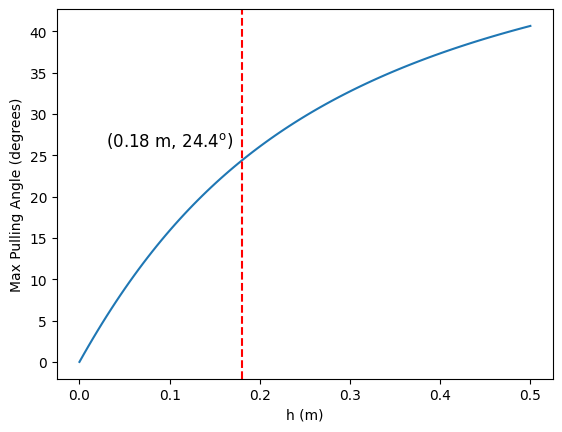

In [207]:
r_lever = 22/100 # m
motorSpeed = 120 # rpm
thetaMax = 30    # degrees

# Calculate max pulling angle
def maxPullAngle(h):
    return 90 - thetaMax - np.arctan(r_lever/(h + r_lever*np.tan(thetaMax*np.pi/180)))*180/np.pi

hs = np.linspace(0, 0.5, 100)
plt.plot(hs, maxPullAngle(hs))
plt.xlabel('h (m)')
plt.ylabel('Max Pulling Angle (degrees)')
h_actual = 0.18
angleMaxActual = fsolve(lambda ang: maxPullAngle(h_actual) - ang, 10)[0]
plt.text(0.95*h_actual, 1.05*angleMaxActual, rf'({h_actual:.3g} m, {angleMaxActual:.3g}$^{{\text{{o}}}}$)', fontsize=12, 
         ha = 'right', va = 'bottom')
plt.axvline(h_actual, color='r', linestyle='--')

# Calculate Max dTheta
spoolD = 15/1000   # m
spoolSpeed = motorSpeed / 60 * np.pi * spoolD # m/s
maxDTheta = spoolSpeed/(r_lever*2*np.pi)*360 # degrees/s
print(f"max dTheta = {maxDTheta:.2g} deg/s")

In [210]:
# Process Parameters
maxTime = 100
maxTheta = 30     # deg
maxDTheta = 25    # deg/s
nPts = 1000
m = 3/1000 # kg
g = 9.81 # m/s^2
b = 1.5e-3 # Ns/m (damping coefficient)

In [214]:
# Process Variable Arrays
times = np.linspace(0, maxTime, nPts)
dTheta = np.zeros(len(times)) # deg/s
theta = np.zeros(len(times))  # deg
pos = np.zeros(len(times))
vel = np.zeros(len(times))
SP = np.zeros(len(times))
Ps = np.zeros(len(times))
Is = np.zeros(len(times))
Ds = np.zeros(len(times))

# Setpoint changes
SP[50:] = 10/100
SP[300:] = -10/100
SP[600:] = 0/100

# Lever differential equation
def lever(state, t):
    thetaVal, dThetaVal = state
    return dThetaVal, 0

# Ball differential equation
def ball(state, t, thetaVal):
    x, dx = state
    return dx, m*g*np.sin(thetaVal) - b*dx/m

def simulate(Kc, KI, KD):
    # Configure PID controller
    pid = pc.PID(Kc, KI, KD, dt=times[1]-times[0], outputLimits=[-maxDTheta, maxDTheta])
    
    # Reset process variables
    theta[:] = 0
    pos[:] = 0
    vel[:] = 0
    
    # Simulate
    for i in range(len(times)-1):
        tArr = [times[i], times[i+1]]
        # Set the setpoint and get PID output
        pid.setpoint = SP[i]
        if theta[i] > maxTheta or theta[i] < -maxTheta:
            Iterm = False
        else:
            Iterm = True
        dTheta[i], Ps[i], Is[i], Ds[i] = pid(pos[i], Iterm)
        # First, integrate for new lever position
        init = [theta[i], dTheta[i]]
        theta[i+1] = max(min(maxTheta, odeint(lever, init, tArr)[-1][0]), -maxTheta)
        # Next, integrate for ball position
        init = [pos[i], vel[i]]
        result = odeint(ball, init, tArr, args=(theta[i]/180*np.pi,))
        pos[i+1], vel[i+1] = result[-1]
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.subplot(4, 1, 1)
    plt.title(f"Max Theta: {maxTheta} deg, Max DTheta: {maxDTheta} deg/s")
    line1, = plt.gca().plot(times, theta, label='Platform Angle (degrees)', color = 'b')
    plt.plot([times[0], times[-1]], [maxTheta, maxTheta], 'b--')
    plt.plot([times[0], times[-1]], [-maxTheta, -maxTheta], 'b--')
    plt.ylabel('Angle (deg)')
    ax = plt.gca().twinx()
    line2, = ax.plot(times, dTheta, label ='Angle Rate (deg/s)', color='r')
    ax.plot([times[0], times[-1]], [maxDTheta, maxDTheta], 'r:')
    ax.plot([times[0], times[-1]], [-maxDTheta, -maxDTheta], 'r:')
    plt.ylabel("Angle Rate (deg/s)")
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels)
    plt.subplot(4, 1, 2)
    plt.plot(times, vel*100, label='Velocity (cm/s)')
    plt.ylabel('Velocity (cm/s)')
    plt.legend()
    plt.subplot(4, 1, 3)
    plt.plot(times, pos*100, label='Position (cm)')
    plt.plot(times, SP*100, label='Setpoint (cm)')
    plt.ylabel('Position (cm)')
    plt.legend()
    plt.subplot(4, 1, 4)
    plt.plot(times, Ps, label='P')
    plt.plot(times, Is, label='I')
    plt.plot(times, Ds, label='D')
    plt.ylabel('PID Terms')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.tight_layout()
    plt.show();

# Ziegler-Nichols Rules
Ku = 400/0.6 # Ultimate gain. Point where system oscillates with KI = KD = 0
Tu = 7  # s, oscillation period
Kc = 0.6*Ku
KI = 2*Kc/Tu
KD = Kc*Tu

# Create interactive sliders
interact(simulate, Kc=widgets.FloatSlider(value=96, min=0.0, max=1000.0, step=0.1),
         KI=widgets.FloatSlider(value=0.0, min=0.0, max=1000.0, step=0.1),
         KD=widgets.FloatSlider(value=580, min=0.0, max=1000.0, step=0.01))
# Manually optimized: 400, 200, 3000
# Optimized values:   96,  0.0, 580

interactive(children=(FloatSlider(value=96.0, description='Kc', max=1000.0), FloatSlider(value=0.0, descriptio…

<function __main__.simulate(Kc, KI, KD)>

### PID Optimization

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 9.153262478008688
             x: [ 9.729e+01  6.938e-05  5.840e+02]
           nit: 80
          nfev: 146
 final_simplex: (array([[ 9.729e+01,  6.938e-05,  5.840e+02],
                       [ 9.729e+01,  6.938e-05,  5.840e+02],
                       [ 9.729e+01,  6.938e-05,  5.840e+02],
                       [ 9.729e+01,  6.937e-05,  5.840e+02]]), array([ 9.153e+00,  9.153e+00,  9.153e+00,  9.153e+00]))


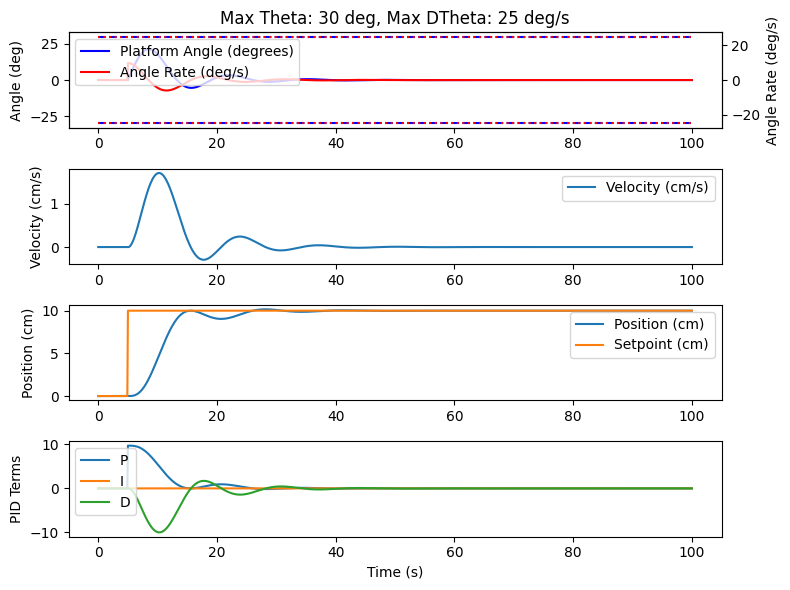

In [213]:
# Process Variable Arrays
times = np.linspace(0, maxTime, nPts)
dTheta = np.zeros(len(times)) # deg/s
theta = np.zeros(len(times))  # deg
pos = np.zeros(len(times))
vel = np.zeros(len(times))
SP = np.zeros(len(times))
Ps = np.zeros(len(times))
Is = np.zeros(len(times))
Ds = np.zeros(len(times))

# Setpoint changes
SP[50:] = 10/100
#SP[100:] = 0

# Lever differential equation
def lever(state, t):
    thetaVal, dThetaVal = state
    return dThetaVal, 0

# Ball differential equation
def ball(state, t, thetaVal):
    x, dx = state
    return dx, m*g*np.sin(thetaVal) - b*dx/m

def simulate(Kc, KI, KD):
    # Configure PID controller
    pid = pc.PID(Kc, KI, KD, dt=times[1]-times[0], outputLimits=[-maxDTheta, maxDTheta])
    
    # Reset process variables
    theta[:] = 0
    pos[:] = 0
    vel[:] = 0
    
    # Simulate
    for i in range(len(times)-1):
        tArr = [times[i], times[i+1]]
        # Set the setpoint and get PID output
        pid.setpoint = SP[i]
        if theta[i] > maxTheta or theta[i] < -maxTheta:
            Iterm = False
        else:
            Iterm = True
        dTheta[i], Ps[i], Is[i], Ds[i] = pid(pos[i], Iterm)
        # First, integrate for new lever position
        init = [theta[i], dTheta[i]]
        theta[i+1] = max(min(maxTheta, odeint(lever, init, tArr)[-1][0]), -maxTheta)
        # Next, integrate for ball position
        init = [pos[i], vel[i]]
        result = odeint(ball, init, tArr, args=(theta[i]/180*np.pi,))
        pos[i+1], vel[i+1] = result[-1]
    return theta, dTheta, pos, vel, SP, Ps, Is, Ds

if input("Run optimization? (y/n): ") == 'y':
    def optimize(args):
        Kc, KI, KD = args
        theta, dTheta, pos, vel, SP, Ps, Is, Ds = simulate(Kc, KI, KD)
        return np.sum(np.abs(SP - pos)) + np.sum(np.abs(theta))/500

    # Optimize parameters
    result = minimize(optimize, [96, 0.0, 580], method='Nelder-Mead')
    print(result)
    Kc, KI, KD = result.x

    # Get data
    theta, dTheta, pos, vel, SP, Ps, Is, Ds = simulate(Kc, KI, KD)
else:
    print("Cancelled optimization")

# Plot results
plt.figure(figsize=(8, 6))
plt.subplot(4, 1, 1)
plt.title(f"Max Theta: {maxTheta} deg, Max DTheta: {maxDTheta} deg/s")
line1, = plt.gca().plot(times, theta, label='Platform Angle (degrees)', color = 'b')
plt.plot([times[0], times[-1]], [maxTheta, maxTheta], 'b--')
plt.plot([times[0], times[-1]], [-maxTheta, -maxTheta], 'b--')
plt.ylabel('Angle (deg)')
ax = plt.gca().twinx()
line2, = ax.plot(times, dTheta, label ='Angle Rate (deg/s)', color='r')
ax.plot([times[0], times[-1]], [maxDTheta, maxDTheta], 'r:')
ax.plot([times[0], times[-1]], [-maxDTheta, -maxDTheta], 'r:')
plt.ylabel("Angle Rate (deg/s)")
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)
plt.subplot(4, 1, 2)
plt.plot(times, vel*100, label='Velocity (cm/s)')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(times, pos*100, label='Position (cm)')
plt.plot(times, SP*100, label='Setpoint (cm)')
plt.ylabel('Position (cm)')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(times, Ps, label='P')
plt.plot(times, Is, label='I')
plt.plot(times, Ds, label='D')
plt.ylabel('PID Terms')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()
plt.show();

## Single-plot

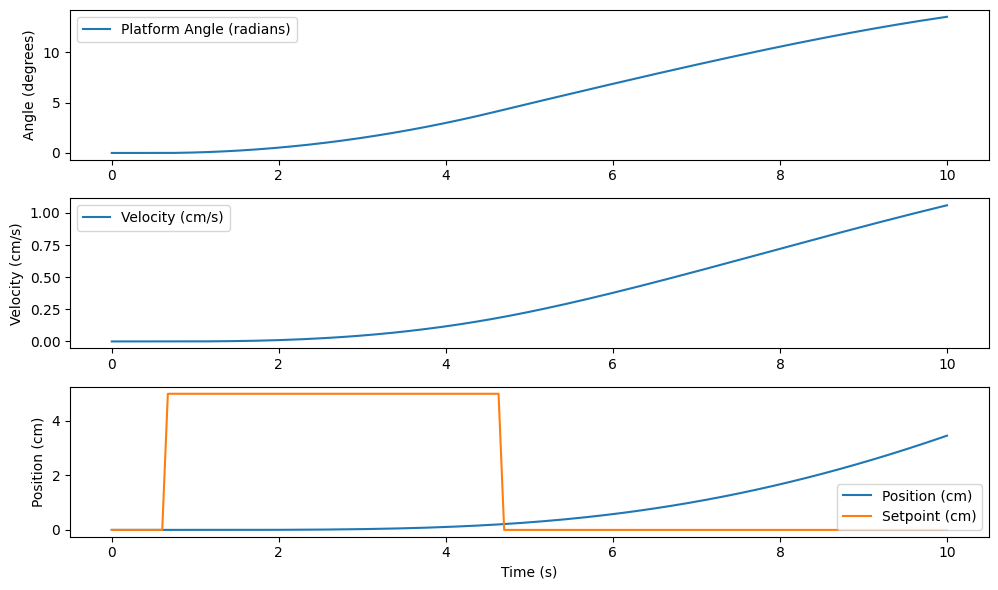

In [75]:
import packages.pc as pc

# Process Parameters
maxTime = 10
nPts = 150
m = 3/1000 # kg
g = 9.81 # m/s^2
b = 1.5e-3 # Ns/m (damping coefficient)

# Process Variable Arrays
times = np.linspace(0, maxTime, nPts)
dTheta = np.zeros(len(times)) # deg/s
theta = np.zeros(len(times))  # deg
pos = np.zeros(len(times))
vel = np.zeros(len(times))
SP = np.zeros(len(times))

# Setpoint changes
SP[10:] = 5/100
SP[70:] = 0

# Configure PID controller
Kc = 1.0
tauI = 0.1
tauD = 0.05
KI = Kc/tauI
KD = Kc*tauD
maxDTheta = 10 # deg/s
pid = pc.PID(Kc, KI, KD, dt = times[1]-times[0], \
             outputLimits=[-maxDTheta, maxDTheta])

# Lever differential equation
def lever(state, t):
    thetaVal, dThetaVal = state
    return dThetaVal, 0

# Ball differential equation
def ball(state, t, thetaVal):
    x, dx = state
    return dx, m*g*np.sin(thetaVal) - b*dx/m

# Simulate
for i in range(len(times)-1):
    tArr = [times[i], times[i+1]]
    # Set the setpoint and get PID output
    pid.setpoint = SP[i]
    dTheta = pid(pos[i])[0]
    # First, integrate for new lever position
    init = [theta[i], dTheta]
    theta[i+1] = max(min(maxTheta, odeint(lever, init, tArr)[-1][0]), -maxTheta)
    # Next, integrate for ball position
    init = [pos[i], vel[i]]
    result = odeint(ball, init, tArr, args=(theta[i]/180*np.pi,))
    pos[i+1], vel[i+1] = result[-1]

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(times, theta, label='Platform Angle (radians)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(times, vel*100, label='Velocity (cm/s)')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(times, pos*100, label='Position (cm)')
plt.plot(times, SP*100, label = 'Setpoint (cm)')
plt.ylabel('Position (cm)')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()